In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [2]:
import os
work_dir = 'NFYA'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATACc')):
    os.makedirs(os.path.join(work_dir, 'scATACc'))
tmp_dir = '/temp_work/ch250798/Scenic/tmp3'

In [3]:
fragments_dict = {'10x_NFYA': os.path.join(work_dir, 'data/atac_fragments.tsv.gz')}

In [4]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/cdata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_NFYA'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [5]:
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [9]:
chromsizes

,Chromosome,Start,End
0,GL456210,0,169725
1,GL456211,0,241735
2,GL456212,0,153618
3,GL456213,0,39340
4,GL456216,0,66673
...,...,...,...
61,chr18,0,90702639
62,chr19,0,61431566
63,chrM,0,16299
64,chrX,0,171031299


In [6]:
#sbatch run_AFmuliomeN_1c.sh

#from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
#bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 #variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 #sample_id_col = 'sample_id',
                 #chromsizes = chromsizes,
                 #bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 #bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 #path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 #n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 #normalize_bigwig = True,
               
                 #temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 #split_pattern = '-')

In [6]:
import pybiomart as pbm
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_NFYA':os.path.join(work_dir, 'scATACc/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATACc/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATACc/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATACc/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATACc/quality_control/profile_data_dict.pkl'), 'wb'))

2024-03-25 11:13:17,818 cisTopic     INFO     Reading 10x_NFYA
2024-03-25 11:15:28,539 cisTopic     INFO     Computing barcode rank plot for 10x_NFYA
2024-03-25 11:15:28,542 cisTopic     INFO     Counting fragments
2024-03-25 11:15:35,842 cisTopic     INFO     Marking barcodes with more than 100
2024-03-25 11:15:35,881 cisTopic     INFO     Returning plot data
2024-03-25 11:15:35,883 cisTopic     INFO     Returning valid barcodes
2024-03-25 11:15:48,178 cisTopic     INFO     Computing duplicate rate plot for 10x_NFYA
2024-03-25 11:16:05,797 cisTopic     INFO     Return plot data
2024-03-25 11:16:05,996 cisTopic     INFO     Computing insert size distribution for 10x_NFYA
2024-03-25 11:16:05,997 cisTopic     INFO     Counting fragments
2024-03-25 11:16:12,658 cisTopic     INFO     Returning plot data
2024-03-25 11:18:11,676 cisTopic     INFO     Computing TSS profile for 10x_NFYA
2024-03-25 11:18:27,630 cisTopic     INFO     Formatting annnotation
2024-03-25 11:18:27,696 cisTopic     IN

/temp_work/ch250798/Scenic/pycisTopic/python/pycisTopic/qc.py:1880: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/temp_work/ch250798/Scenic/pycisTopic/python/pycisTopic/qc.py:1895: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/temp_work/ch250798/Scenic/pycisTopic/python/pycisTopic/qc.py:1880

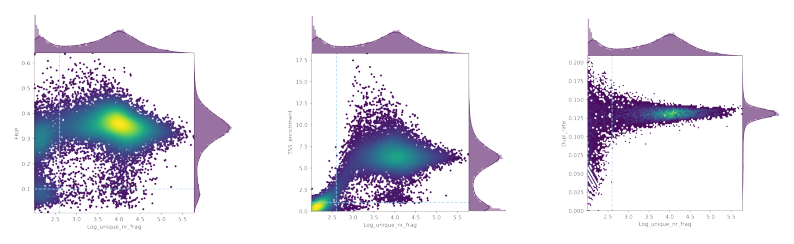

In [56]:
#Adjust BC to pass at least 5000 cells
                        #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [2.6 , None],
    'FRIP':               [0.1, None],
    'TSS_enrichment':     [1.0   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [57]:
bc_passing_filters = {'10x_NFYA':[]}
bc_passing_filters['10x_NFYA'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATACc/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_NFYA'])} barcodes passed QC stats")

9455 barcodes passed QC stats


In [58]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/cdata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_NFYA'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [59]:
import pickle
fragments_dict = {'10x_NFYA': os.path.join(work_dir, 'data/atac_fragments.tsv.gz')}
path_to_regions = {'10x_NFYA':os.path.join(work_dir, 'scATACc/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '/temp_work/ch250798/Scenic/pycisTopic/blacklist/mm10-blacklist.v2.bed',
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATACc/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATACc/quality_control/bc_passing_filters.pkl'), 'rb'))

In [60]:
print(f"{len(list(set(bc_passing_filters['10x_NFYA']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

3440 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


In [61]:
from pycisTopic.cistopic_class import *
key = '10x_NFYA'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist='/temp_work/ch250798/Scenic/pycisTopic/blacklist/mm10-blacklist.v2.bed',
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)


2024-03-25 11:35:20,662 cisTopic     INFO     Reading data for 10x_NFYA
2024-03-25 11:38:16,952 cisTopic     INFO     metrics provided!
2024-03-25 11:38:45,955 cisTopic     INFO     valid_bc provided, selecting barcodes!
2024-03-25 11:39:03,450 cisTopic     INFO     Counting fragments in regions
2024-03-25 11:40:26,434 cisTopic     INFO     Creating fragment matrix
2024-03-25 11:41:14,466 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-03-25 11:41:23,758 cisTopic     INFO     Removing blacklisted regions
2024-03-25 11:41:26,377 cisTopic     INFO     Creating CistopicObject
2024-03-25 11:41:28,661 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project 10x_NFYA with n_cells × n_regions = 3440 × 213590


In [62]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATACc/cistopic_obj.pkl'), 'wb'))

In [19]:
#sbatch run_AFmultiomeN3c.sh

#import pickle
#cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
#from pycisTopic.cistopic_class import *
#models=run_cgs_models(cistopic_obj,
                    #n_topics=[2,4,10,16,32,48],
                    #n_cpu=5,
                    #n_iter=500,
                    #random_state=555,
                    #alpha=50,
                    #alpha_by_topic=True,
                    #eta=0.1,
                    #eta_by_topic=False,
                    #save_path=None,
                    #_temp_dir = os.path.join(tmp_dir + 'ray_spill'))

In [20]:
#included in run_AFmultiomeN3c.sh

#import pickle
#if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    #os.makedirs(os.path.join(work_dir, 'scATAC/models'))

#pickle.dump(models,
 #           open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

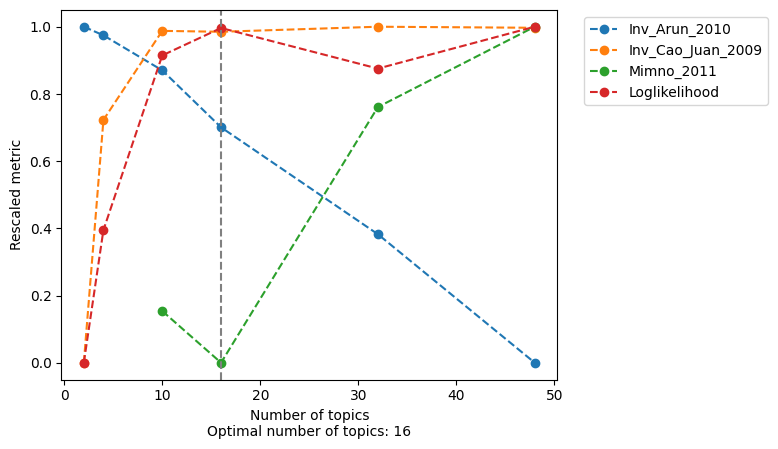

In [1]:
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

import os
work_dir = 'NFYA'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/temp_work/ch250798/Scenic/tmp2'

models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_NFYA_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [2]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2024-03-06 09:33:44,064 cisTopic     INFO     Running UMAP


/home/ch250798/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


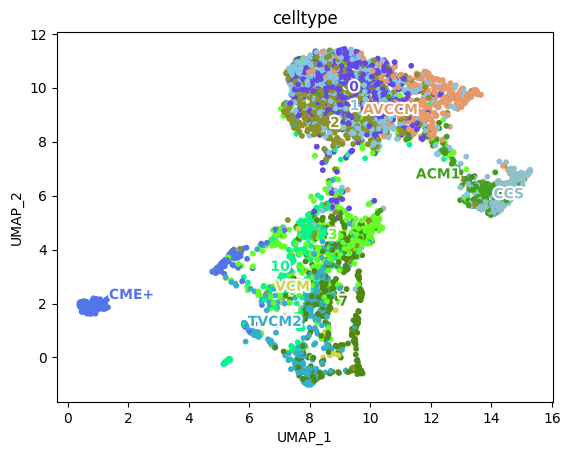

In [3]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

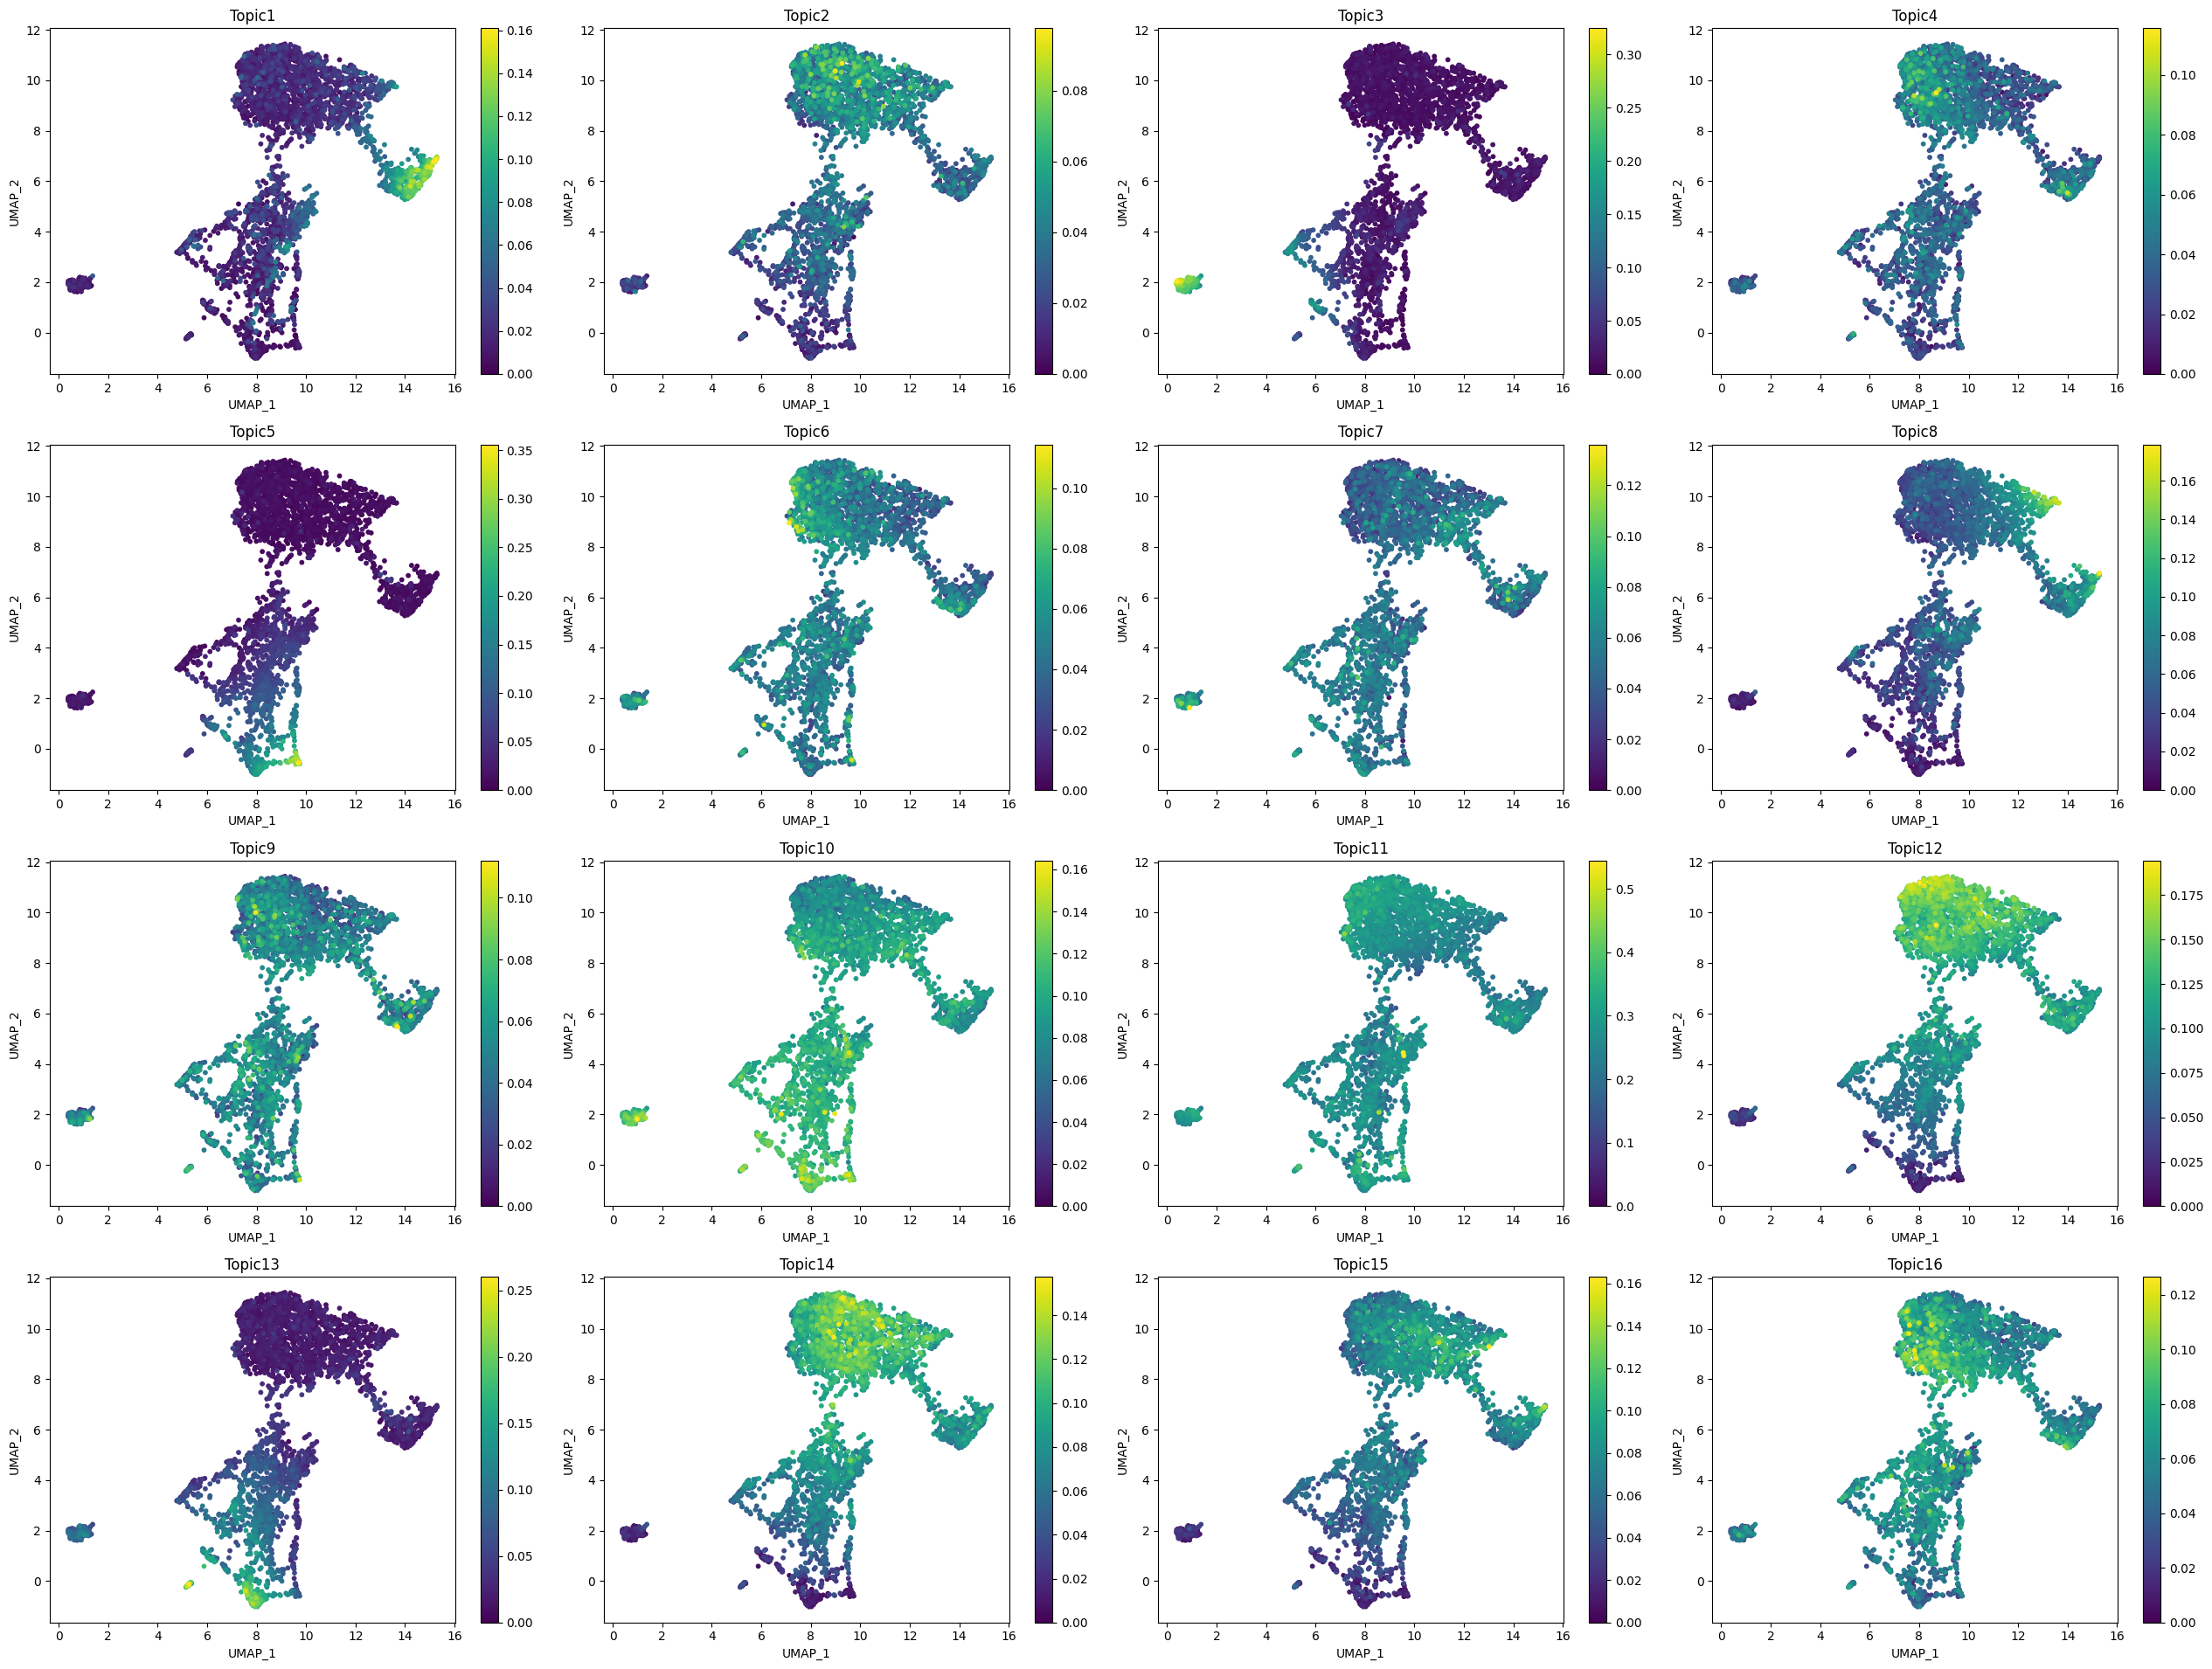

In [4]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

In [5]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2024-03-06 09:34:35,891 cisTopic     INFO     Imputing region accessibility
2024-03-06 09:34:35,892 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-03-06 09:34:36,666 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-03-06 09:34:37,433 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-03-06 09:34:38,197 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-03-06 09:34:38,964 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-03-06 09:34:39,730 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-03-06 09:34:40,497 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-03-06 09:34:41,266 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-03-06 09:34:42,031 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-03-06 09:34:42,802 cisTopic     

<Figure size 640x480 with 0 Axes>

In [7]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

In [8]:
print(markers_dict) 

{'0':                             Log2FC  Adjusted_pval Contrast
chr18:61567515-61568015   0.741775   2.172988e-59        0
chr16:37527187-37527687   0.732500   1.360224e-58        0
chr2:94240212-94240712    0.732378   3.434638e-59        0
chr7:125755181-125755681  0.727865   1.013840e-59        0
chr5:113880259-113880759  0.725257   2.900392e-59        0
...                            ...            ...      ...
chr11:77365114-77365614   0.585257   2.172797e-61        0
chr13:36122806-36123306   0.585150   3.453292e-82        0
chr8:86360296-86360796    0.585146   9.645723e-87        0
chr6:91792993-91793493    0.585114   9.706092e-83        0
chr6:119040211-119040711  0.584967   4.992372e-68        0

[919 rows x 3 columns], '1':                             Log2FC  Adjusted_pval Contrast
chr1:39286008-39286508    0.662669   1.267258e-88        1
chr9:35052876-35053376    0.653387   7.055265e-91        1
chr3:84897944-84898444    0.653373   1.158274e-81        1
chr19:7594304-759480

In [10]:
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    if len(regions) == 0:
      print(DAR)

2


In [11]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    if len(regions) > 0:
        region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [12]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['0', '1', '10', '3', '7', 'ACM1', 'AVCCM', 'CCS', 'CME+', 'TVCM2', 'VCM'])


In [13]:
region_sets['DARs']

{'0': +--------------+-----------+-----------+
 | Chromosome   | Start     | End       |
 | (category)   | (int64)   | (int64)   |
 |--------------+-----------+-----------|
 | chr1         | 35785054  | 35785554  |
 | chr1         | 127834231 | 127834731 |
 | chr1         | 134711002 | 134711502 |
 | chr1         | 189895094 | 189895594 |
 | ...          | ...       | ...       |
 | chrX         | 5925766   | 5926266   |
 | chrX         | 105774071 | 105774571 |
 | chrX         | 50962894  | 50963394  |
 | chrX         | 133738936 | 133739436 |
 +--------------+-----------+-----------+
 Unstranded PyRanges object has 919 rows and 3 columns from 20 chromosomes.
 For printing, the PyRanges was sorted on Chromosome.,
 '1': +--------------+-----------+-----------+
 | Chromosome   | Start     | End       |
 | (category)   | (int64)   | (int64)   |
 |--------------+-----------+-----------|
 | chr1         | 39286008  | 39286508  |
 | chr1         | 189895094 | 189895594 |
 | chr1         | 1

In [ ]:
##remove clusters CD14-Mono, MPP Ribo-high, MPP SPINK2-CD99
adata_filtered = adata[adata.obs['celltype'] != '2' ] #MPP Ribo-high
#adata_filtered = adata_filtered[adata_filtered.obs['cell_type'] != 'CD14-Mono' ] #CD14-Mono
#adata_filtered = adata_filtered[adata_filtered.obs['cell_type'] != 'MPP SPINK2-CD99' ] #MPP SPINK2-CD99
adata_filtered.obs.cell_type
adata = adata_filtered ##replace original adata with filtered one
del(adata_filtered)
